<a href="https://colab.research.google.com/github/cjs220/active_learning_ratio_estimation/blob/master/examples/multidim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# uncomment the code below to temporarily install active_learning_ratio_estimation from source
# if you do not do this, unless you already have it installed in this environment, this notebook will not run

import os, sys, tempfile, shutil
original_dir = os.getcwd()
REPO_NAME = 'active_learning_ratio_estimation'
BRANCH = 'master'
tempdir = tempfile.gettempdir()
os.chdir(tempdir)
if os.path.exists(REPO_NAME):
  print('Removing repo')
  shutil.rmtree(REPO_NAME)
print('Cloning repo')
os.system(f'git clone --single-branch --branch {BRANCH} https://github.com/cjs220/{REPO_NAME}.git')
sys.path.insert(0, os.path.join(tempdir, REPO_NAME))
os.chdir(original_dir)

Cloning repo


In [2]:
!pip install corner
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from corner import corner
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from sklearn import clone
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.datasets import make_sparse_spd_matrix

from active_learning_ratio_estimation.model import SinglyParameterizedRatioModel, DenseClassifier, FlipoutClassifier
from active_learning_ratio_estimation.dataset import ParamGrid, SinglyParameterizedRatioDataset

%matplotlib inline

np.random.seed(0)
tf.random.set_seed(0)

  Created wheel for corner: filename=corner-2.0.1-cp36-none-any.whl size=11642 sha256=c6d8470c544c5286535c888b13db78e4ddfe8832278156b9b30f8d60c8046be6
  Stored in directory: /root/.cache/pip/wheels/70/d8/e5/e0e7974a2a5757483ea5a180c937041cf6872dc9993d78234a
Successfully built corner


In [0]:
class MultiDimToyModel(tfd.TransformedDistribution):

    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

        # compose linear transform
        R = make_sparse_spd_matrix(5, alpha=0.5, random_state=7).astype(np.float32)
        self.R = R
        transform = tf.linalg.LinearOperatorFullMatrix(R)
        bijector = tfp.bijectors.AffineLinearOperator(scale=transform)

        super().__init__(distribution=self.z_distribution, bijector=bijector)

    @property
    def z_distribution(self):
        z_distribution = tfd.Blockwise([
            tfd.Normal(loc=self.alpha, scale=1),  # z1
            tfd.Normal(loc=self.beta, scale=3),  # z2
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=[0.5, 0.5]),
                components_distribution=tfd.Normal(
                    loc=[-2, 2],
                    scale=[1, 0.5]
                )
            ),  # z3
            tfd.Exponential(3),  # z4
            tfd.Exponential(0.5),  # z5
        ])
        return z_distribution

Instructions for updating:
`AffineLinearOperator` bijector is deprecated; please use `tfb.Shift(loc)(tfb.ScaleMatvecLinearOperator(...))`.


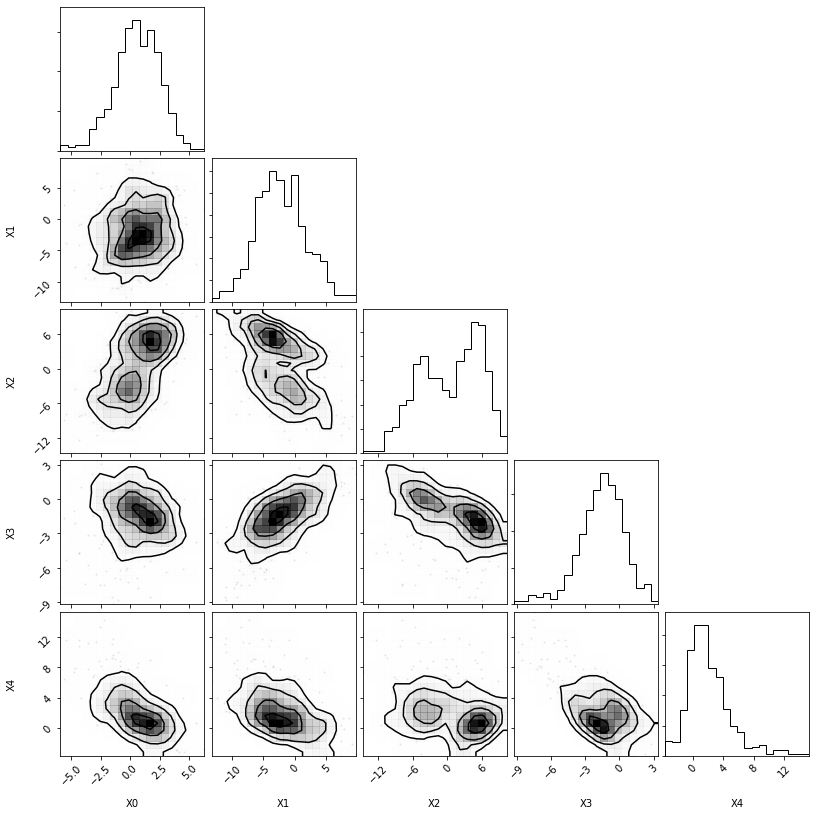

In [4]:
# Plot histograms / correlations of true distributions
true_alpha = 1
true_beta = -1
p_true = MultiDimToyModel(alpha=1, beta=-1)
X_true = p_true.sample(500)
fig = corner(X_true, bins=20, smooth=0.85, labels=["X0", "X1", "X2", "X3", "X4"])

In [5]:
# find exact maximum likelihood
var_alpha = tf.Variable(tf.constant(0, dtype=tf.float32))
var_beta = tf.Variable(tf.constant(0, dtype=tf.float32))
p_var = MultiDimToyModel(var_alpha, var_beta)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
n_iter = int(1e3)
nll = tf.function(lambda: -tf.keras.backend.sum(p_var.log_prob(X_true)))

for i in range(n_iter):
    optimizer.minimize(nll, [var_alpha, var_beta])

alpha_mle = var_alpha.numpy()
beta_mle = var_beta.numpy()
theta_mle = np.array([alpha_mle, beta_mle])
max_log_prob = p_var.log_prob(X_true)

print(f'\nExact MLE: alpha={alpha_mle:.2f}, beta={beta_mle:.2f}')


Exact MLE: alpha=0.99, beta=-1.19


In [0]:
# create dataset for fitting
param_grid_train = ParamGrid(bounds=[(-3, 3), (-3, 3)], num=30)
theta_0 = np.array([alpha_mle, beta_mle])
ds = SinglyParameterizedRatioDataset.from_simulator(
    simulator_func=MultiDimToyModel,
    theta_0=theta_0,
    theta_1_iterator=param_grid_train,
    n_samples_per_theta=int(1e3)
)

In [0]:
# hyperparams
epochs = 100
patience = 5
validation_split = 0.1
n_hidden = (30, 30)

# create model
bayesian_estimator = FlipoutClassifier(n_hidden=n_hidden, activation='tanh',
                                       epochs=epochs, patience=patience,
                                       validation_split=validation_split)
model = SinglyParameterizedRatioModel(estimator=bayesian_estimator, calibration_method=None)

# fit model
model.fit(ds)

Epoch 1/100
Instructions for updating:
Please use `layer.add_weight` method instead.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

50625/50625 - 91s - loss: 0.4116 - accuracy: 0.7899 - val_loss: 0.4000 - val_accuracy: 0.7976
Epoch 2/100


In [0]:
import time

# predict log-likelihood contours
num_plot = 10
alpha_bounds = (0.75, 1.25)
beta_bounds = (-2, 0)
plot_grid = ParamGrid(bounds=[alpha_bounds, beta_bounds], num=num_plot)
Alphas, Betas = plot_grid.meshgrid()

t0 = time.time()
pred_contours, (pred_alpha, pred_beta) = model.nllr_param_scan(x=X_true, param_grid=plot_grid)
print(f'Precition Time: {int(time.time()- t0)} s')

In [0]:
import matplotlib.pyplot as plt

# for item in ('val_loss', 'loss', 'accuracy', 'val_accuracy'):
  # print(model.estimator.steps[-1][1].model_.history.history)
  # plt.plot(model.estimator.steps[-1][1].model_.history.history[item], label=item)

# plt.legend()
# plt.show()
print(pred_alpha, pred_beta)

In [0]:
# Calculate contours of exact negative log likelihood ratio

@tf.function
def nllr_exact(alpha, beta, X):
    p_theta = MultiDimToyModel(alpha=alpha, beta=beta)
    return -tf.keras.backend.sum((p_theta.log_prob(X) - max_log_prob))


exact_contours = np.zeros_like(Alphas)
for i in range(num_plot):
    for j in range(num_plot):
        alpha = tf.constant(Alphas[i, j])
        beta = tf.constant(Betas[i, j])
        nllr = nllr_exact(alpha, beta, X_true)
        exact_contours[i, j] = nllr

In [0]:
# Plot exact and predicted contours
def plot_contours(contours):
    plt.contour(*plot_grid.meshgrid(), 2 * contours, levels=[chi2.ppf(0.683, df=2),
                                                            chi2.ppf(0.9545, df=2),
                                                            chi2.ppf(0.9973, df=2)], colors=["w"])
    plt.contourf(*plot_grid.meshgrid(), 2 * contours, vmin=0, vmax=30)
    plt.plot([true_alpha], [true_beta], "ro", markersize=8, label='True')
    plt.plot([alpha_mle], [beta_mle], "go", markersize=8, label='MLE')
    plt.plot([pred_alpha], [pred_beta], 'bo', markersize=8, label='Predicted')
    plt.xlim(*alpha_bounds)
    plt.ylim(*beta_bounds)
    plt.xlabel(r"$\alpha$")
    plt.ylabel(r"$\beta$")
    plt.colorbar()
    plt.legend()



plot_contours(exact_contours)

In [0]:
contour_mae = np.abs(pred_contours - exact_contours).mean()
print('Contour MAE: ', contour_mae)
plot_contours(pred_contours)
plt.legend()

In [0]:
from active_learning_ratio_estimation.model.validation import plot_calibration
plot_calibration(model, dataset=ds, n_data=int(1e3))